In [ ]:
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

In [ ]:
pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("C:\\Users\\Landry Tun\\Documents\\Master's_second_semester\\CSE 572 Data_Minning\\HW1\\24_train_1.csv")
df

,ArticleId,Text,Category
0,1429,sfa awaits report over mikoliunas the scottish...,sport
1,1896,parmalat to return to stockmarket parmalat th...,business
2,1633,edu blasts arsenal arsenal s brazilian midfiel...,sport
3,2178,henman decides to quit davis cup tim henman ha...,sport
4,194,french suitor holds lse meeting european stock...,business
...,...,...,...
995,1250,blair damaged by blunkett row a majority of ...,politics
996,1639,a november to remember last saturday one news...,sport
997,916,highbury tunnel players in clear the football ...,sport
998,2217,top stars join us tsunami tv show brad pitt r...,entertainment


In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed


[nltk_data] Downloading package punkt to C:\Users\Landry
[nltk_data]     Tun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Landry
[nltk_data]     Tun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import numpy as np


def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary


def get_doc_tf(word_set, dictionary):
    n_words = len(dictionary)
    tf_vec = np.zeros(n_words)

    max_cnt = 0
    for word in word_set:
        idx = dictionary[word]
        tf_vec[idx] += 1.0

        if tf_vec[idx] > max_cnt:
            max_cnt = tf_vec[idx]

    return tf_vec / max_cnt



def get_tf_idf(tf_dict, df_vec, n_doc, n_words):

    tf_idf_mtx = np.zeros((n_doc, n_words))
    idf = np.log(n_doc / df_vec)

    for doc_idx, tf_vec in tf_dict.items():
        tf_idf = tf_dict[doc_idx]*idf

        tf_idf_mtx[doc_idx, :] = tf_idf

    return tf_idf_mtx


def write(d, fpath):

    with open(fpath, "w") as f:

        for k, v in d.items():

            f.write(f"{k}\n")


def filter_top_k(counter_sorted, limit):
    top_k = {}

    for i, k in enumerate(counter_sorted.keys()):
        if i == limit:
            break
        top_k[k] = counter_sorted[k]

    return top_k

In [ ]:
def tfidf_main(fpath, dictionary):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            id, txt, cat = line.split(",")
            cat = cat.strip()
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

In [ ]:
dictionary = get_dict("dictionary.txt")
tfidf = tfidf_main("24_train_1.csv", dictionary)
np.savetxt("tfidf.txt", tfidf,  fmt='%.4f', delimiter=",")

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:04<00:00, 15.51it/s]


In [ ]:
tfidf

array([[0.28878469, 0.        , 0.36036196, ..., 0.51540439, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.15158953, 0.        ,
        0.        ]])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random as python_random

def reset_random_seeds(seed_value=42):
   np.random.seed(seed_value)
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)
reset_random_seeds()


X_raw = df['Text']
y_raw = df['Category']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

y_onehot = to_categorical(y_encoded)


vectorizer = CountVectorizer(ngram_range=(1, 2))

X_vectorized = vectorizer.fit_transform(X_raw)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def create_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


acc_per_fold = []
loss_per_fold = []
training_histories = []


for train_ix, test_ix in kfold.split(X_vectorized, y_encoded):

    model = create_model(input_dim=X_vectorized.shape[1], output_dim=y_onehot.shape[1])


    history = model.fit(X_vectorized[train_ix].toarray(), y_onehot[train_ix],
                        validation_data=(X_vectorized[test_ix].toarray(), y_onehot[test_ix]),
                        epochs=20, batch_size=64, verbose=0)

    training_histories.append(history)


    scores = model.evaluate(X_vectorized[test_ix].toarray(), y_onehot[test_ix], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


train_accs = [np.mean(history.history['accuracy']) * 100 for history in training_histories]
train_losses = [np.mean(history.history['loss']) for history in training_histories]
val_accs = [np.mean(history.history['val_accuracy']) * 100 for history in training_histories]
val_losses = [np.mean(history.history['val_loss']) for history in training_histories]


print(f'Average Training Accuracy: {np.mean(train_accs):.2f}% (± {np.std(train_accs):.2f}%)')
print(f'Average Training Loss: {np.mean(train_losses):.2f} (± {np.std(train_losses):.2f})')
print(f'Average Validation Accuracy: {np.mean(val_accs):.2f}% (± {np.std(val_accs):.2f}%)')
print(f'Average Validation Loss: {np.mean(val_losses):.2f} (± {np.std(val_losses):.2f})')
print(f'Average Test Accuracy: {np.mean(acc_per_fold):.2f}% (± {np.std(acc_per_fold):.2f}%)')
print(f'Average Test Loss: {np.mean(loss_per_fold):.2f} (± {np.std(loss_per_fold):.2f})')


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Average Training Accuracy: 98.92% (± 0.10%)
Average Training Loss: 0.04 (± 0.00)
Average Validation Accuracy: 93.50% (± 2.26%)
Average Validation Loss: 0.24 (± 0.10)
Average Test Accuracy: 93.90% (± 2.27%)
Average Test Loss: 0.23 (± 0.09)


In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

def reset_random_seeds(seed_value=42):
   np.random.seed(seed_value)
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)

reset_random_seeds()


X = tfidf
y = df['Category']

# Encode the categorical labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Convert the integer encoded labels to one-hot encoded vectors
y_categorical = to_categorical(y_encoded)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define your neural network architecture
def create_network(num_features):
    network = Sequential()
    network.add(Dense(128, input_shape=(num_features,), activation='relu'))
    network.add(Dense(128, activation='relu'))
    network.add(Dense(y_categorical.shape[1], activation='softmax'))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return network

# Initialize lists to store the results
acc_per_fold = []
loss_per_fold = []
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Execute the cross-validation
for train, test in kfold.split(X, y_encoded):
    # Create a new model instance for each fold
    model = create_network(X.shape[1])

    # Split training data for a portion to use as validation
    val_split = int(len(train) * 0.8)
    train_indices, val_indices = train[:val_split], train[val_split:]

    # Fit the model to the training data of the current fold
    history = model.fit(X[train_indices], y_categorical[train_indices], validation_data=(X[val_indices], y_categorical[val_indices]), epochs=20, batch_size=64, verbose=0)

    # Store the training and validation history
    train_accs.append(np.mean(history.history['accuracy']) * 100)
    train_losses.append(np.mean(history.history['loss']))
    val_accs.append(np.mean(history.history['val_accuracy']) * 100)
    val_losses.append(np.mean(history.history['val_loss']))

    # Evaluate the model on the test data of the current fold
    scores = model.evaluate(X[test], y_categorical[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


print(f'Average Training Accuracy: {np.mean(train_accs):.2f}% (± {np.std(train_accs):.2f}%)')
print(f'Average Training Loss: {np.mean(train_losses):.2f} (± {np.std(train_losses):.2f})')
print(f'Average Validation Accuracy: {np.mean(val_accs):.2f}% (± {np.std(val_accs):.2f}%)')
print(f'Average Validation Loss: {np.mean(val_losses):.2f} (± {np.std(val_losses):.2f})')
print(f'Average Test Accuracy: {np.mean(acc_per_fold):.2f}% (± {np.std(acc_per_fold):.2f}%)')
print(f'Average Test Loss: {np.mean(loss_per_fold):.2f} (± {np.std(loss_per_fold):.2f})')


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Average Training Accuracy: 97.14% (± 0.09%)
Average Training Loss: 0.15 (± 0.01)
Average Validation Accuracy: 97.04% (± 0.56%)
Average Validation Loss: 0.17 (± 0.01)
Average Test Accuracy: 95.70% (± 1.86%)
Average Test Loss: 0.12 (± 0.05)


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

# Path to the GloVe file
glove_input_file = 'glove.42B.300d.txt'
word2vec_output_file = 'glove.42B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in word2vec_model.key_to_index]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model[doc], axis=0)

X_vectorized = np.array([document_vector(glove_model, text) for text in X_raw])





C:\Users\Landry Tun\AppData\Local\Temp\ipykernel_24260\1680337337.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

def reset_random_seeds(seed_value=42):
   np.random.seed(seed_value)
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)

reset_random_seeds()


y = df['Category']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_network(num_features):
    network = Sequential()
    network.add(Dense(128, input_shape=(num_features,), activation='relu'))
    network.add(Dense(128, activation='relu'))
    network.add(Dense(y_categorical.shape[1], activation='softmax'))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return network


acc_per_fold = []
loss_per_fold = []
train_accs = []
train_losses = []
val_accs = []
val_losses = []


for train, test in kfold.split(X, y_encoded):

    model = create_network(X.shape[1])


    val_split = int(len(train) * 0.8)
    train_indices, val_indices = train[:val_split], train[val_split:]


    history = model.fit(X[train_indices], y_categorical[train_indices], validation_data=(X[val_indices], y_categorical[val_indices]), epochs=20, batch_size=64, verbose=0)


    train_accs.append(np.mean(history.history['accuracy']) * 100)
    train_losses.append(np.mean(history.history['loss']))
    val_accs.append(np.mean(history.history['val_accuracy']) * 100)
    val_losses.append(np.mean(history.history['val_loss']))


    scores = model.evaluate(X[test], y_categorical[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


print(f'Average Training Accuracy: {np.mean(train_accs):.2f}% (± {np.std(train_accs):.2f}%)')
print(f'Average Training Loss: {np.mean(train_losses):.2f} (± {np.std(train_losses):.2f})')
print(f'Average Validation Accuracy: {np.mean(val_accs):.2f}% (± {np.std(val_accs):.2f}%)')
print(f'Average Validation Loss: {np.mean(val_losses):.2f} (± {np.std(val_losses):.2f})')
print(f'Average Test Accuracy: {np.mean(acc_per_fold):.2f}% (± {np.std(acc_per_fold):.2f}%)')
print(f'Average Test Loss: {np.mean(loss_per_fold):.2f} (± {np.std(loss_per_fold):.2f})')


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Average Training Accuracy: 90.77% (± 0.53%)
Average Training Loss: 0.39 (± 0.01)
Average Validation Accuracy: 92.34% (± 0.30%)
Average Validation Loss: 0.36 (± 0.01)
Average Test Accuracy: 95.60% (± 2.03%)
Average Test Loss: 0.11 (± 0.02)


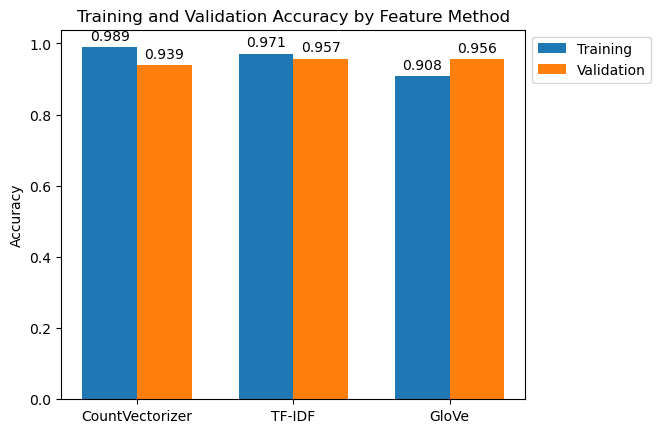

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


train_accuracy_cv = 0.989
validation_accuracy_cv = 0.939
train_accuracy_tfidf = 0.971
validation_accuracy_tfidf = 0.957
train_accuracy_glove = 0.908
validation_accuracy_glove = 0.956

labels = ['CountVectorizer', 'TF-IDF', 'GloVe']
train_accuracies = [train_accuracy_cv, train_accuracy_tfidf, train_accuracy_glove]
validation_accuracies = [validation_accuracy_cv, validation_accuracy_tfidf, validation_accuracy_glove]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training')
rects2 = ax.bar(x + width/2, validation_accuracies, width, label='Validation')


plt.subplots_adjust(right=0.85)


ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Feature Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical


learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]


results = []


kfold = StratifiedKFold(n_splits=5, shuffle=True)

for lr in learning_rates:

    fold_training_accuracies = []
    fold_testing_accuracies = []

    for train, test in kfold.split(X, y_encoded):

        model = create_network(X.shape[1])


        model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])


        history = model.fit(X[train], y_categorical[train], validation_data=(X[test], y_categorical[test]), epochs=20, batch_size=64, verbose=0)


        fold_training_accuracies.append(history.history['accuracy'])
        fold_testing_accuracies.append(history.history['val_accuracy'])


    avg_train_acc = np.mean(fold_training_accuracies)
    std_train_acc = np.std(fold_training_accuracies)
    avg_test_acc = np.mean(fold_testing_accuracies)
    std_test_acc = np.std(fold_testing_accuracies)


    results.append((lr, avg_train_acc, std_train_acc, avg_test_acc, std_test_acc))


import pandas as pd

results_df = pd.DataFrame(results, columns=['Learning Rates', 'Training Accuracy', 'Training Acc Std Dev', 'Testing Accuracy', 'Testing Acc Std Dev'])
print(results_df)


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 

   Learning Rates  Training Accuracy  Training Acc Std Dev  Testing Accuracy  \
0          0.0001           0.682188              0.220718           0.69605   
1          0.0003           0.833825              0.181983           0.85060   
2          0.0010           0.921613              0.130163           0.93040   
3          0.0030           0.949725              0.098648           0.94970   
4          0.0100           0.954987              0.091391           0.94415   
5          0.0300           0.943125              0.112391           0.93350   
6          0.1000           0.811288              0.181852           0.79780   

   Testing Acc Std Dev  
0             0.208337  
1             0.157253  
2             0.081620  
3             0.027539  
4             0.025554  
5             0.054596  
6             0.140709  


In [ ]:
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import random as python_random

def reset_random_seeds(seed_value=42):
   np.random.seed(seed_value)
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)


reset_random_seeds()


learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]


results = []


y = df['Category']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def create_network(num_features):
    network = Sequential()
    network.add(Dense(128, input_shape=(num_features,), activation='relu'))
    network.add(Dense(128, activation='relu'))
    network.add(Dense(y_categorical.shape[1], activation='softmax'))
    return network


for lr in learning_rates:

    fold_training_accuracies = []
    fold_validation_accuracies = []

    for train, test in kfold.split(X_tfidf, y_encoded):

        model = create_network(X_tfidf.shape[1])
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


        history = model.fit(X_tfidf[train], y_categorical[train], epochs=20, batch_size=64, verbose=0, validation_data=(X_tfidf[test], y_categorical[test]))


        fold_training_accuracies.append(history.history['accuracy'])
        fold_validation_accuracies.append(history.history['val_accuracy'])

    avg_train_acc = np.mean(fold_training_accuracies)
    std_train_acc = np.std(fold_training_accuracies)
    avg_val_acc = np.mean(fold_validation_accuracies)
    std_val_acc = np.std(fold_validation_accuracies)


    results.append((lr, avg_train_acc, std_train_acc, avg_val_acc, std_val_acc))


import pandas as pd

results_df = pd.DataFrame(results, columns=['Learning Rate', 'Training Accuracy', 'Training Acc Std Dev', 'Validation Accuracy', 'Validation Acc Std Dev'])
print(results_df)


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 

   Learning Rate  Training Accuracy  Training Acc Std Dev  \
0         0.0001           0.841800              0.208143   
1         0.0003           0.938187              0.156811   
2         0.0010           0.972938              0.100251   
3         0.0030           0.985412              0.058944   
4         0.0100           0.989187              0.041450   
5         0.0300           0.987075              0.049973   
6         0.1000           0.965225              0.083525   

   Validation Accuracy  Validation Acc Std Dev  
0              0.81330                0.188413  
1              0.91680                0.103965  
2              0.95860                0.035434  
3              0.96040                0.018597  
4              0.94970                0.013338  
5              0.95215                0.014479  
6              0.92575                0.028951  


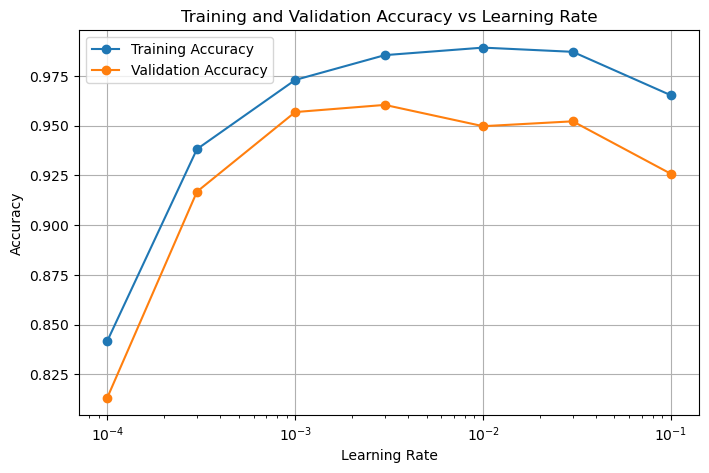

In [ ]:
import matplotlib.pyplot as plt

# Given learning rates and accuracies from TF-IDF results
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
training_accuracies = [0.841800, 0.938187, 0.972938, 0.985412, 0.989187, 0.987075, 0.965225]
validation_accuracies = [0.813300, 0.916800, 0.956800, 0.960400, 0.949700, 0.952150, 0.925750]

plt.figure(figsize=(8, 5))
plt.plot(learning_rates, training_accuracies, 'o-', label='Training Accuracy')
plt.plot(learning_rates, validation_accuracies, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')  # To represent the learning rates on a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 

  Optimizer  Training Accuracy  Training Acc Std Dev  Validation Accuracy  \
0       SGD           0.503250              0.177831              0.47245   
1      Adam           0.974687              0.094420              0.95490   
2   RMSprop           0.983412              0.063664              0.96360   

   Validation Acc Std Dev  
0                0.168882  
1                0.029077  
2                0.022362  


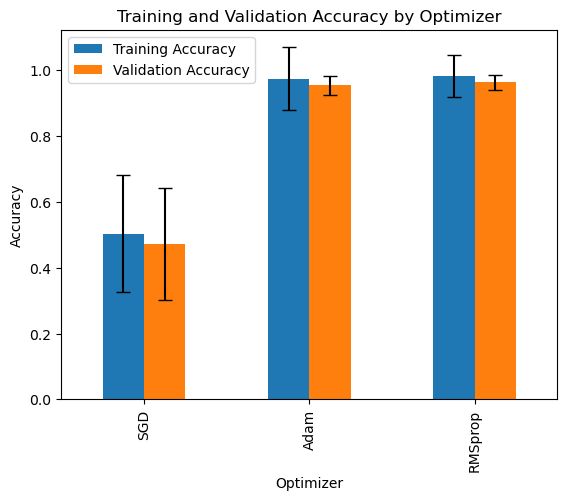

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

def create_model(optimizer_name, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Instantiate a new optimizer based on the name provided
    if optimizer_name == 'SGD':
        optimizer = SGD()
    elif optimizer_name == 'Adam':
        optimizer = Adam()
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



y = df['Category']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


optimizers = [SGD(), Adam(), RMSprop()]
optimizer_names = ['SGD', 'Adam', 'RMSprop']
results = []

for optimizer_name in optimizer_names:
    fold_acc = []
    fold_val_acc = []
    for train, test in kfold.split(X_tfidf, y_encoded):

        model = create_model(optimizer_name, input_dim=X_tfidf.shape[1], output_dim=y_onehot.shape[1])
        history = model.fit(X_tfidf[train], y_onehot[train], epochs=20, batch_size=64, verbose=0, validation_data=(X_tfidf[test], y_onehot[test]))
        fold_acc.append(history.history['accuracy'])
        fold_val_acc.append(history.history['val_accuracy'])


    avg_train_acc = np.mean(fold_acc)
    std_train_acc = np.std(fold_acc)
    avg_val_acc = np.mean(fold_val_acc)
    std_val_acc = np.std(fold_val_acc)

    results.append([optimizer_name, avg_train_acc, std_train_acc, avg_val_acc, std_val_acc])


results_df = pd.DataFrame(results, columns=['Optimizer', 'Training Accuracy', 'Training Acc Std Dev', 'Validation Accuracy', 'Validation Acc Std Dev'])
print(results_df)


results_df.set_index('Optimizer', inplace=True)
results_df[['Training Accuracy', 'Validation Accuracy']].plot(kind='bar', yerr=results_df[['Training Acc Std Dev', 'Validation Acc Std Dev']].values.T, error_kw=dict(capsize=5))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy by Optimizer')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

def create_mlp_model(input_dim, output_dim):
    # Define the MLP model
    model = Sequential()
    model.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    return model


x_tfidf = tfidf
y = df['Category']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Category'])
y_onehot = to_categorical(y_encoded)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracy_per_fold = []

for train, test in kfold.split(x_tfidf, y_encoded):

    model_net = create_mlp_model(x_tfidf.shape[1], y_onehot.shape[1])
    model_net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



    print(f'Training for fold {fold_no} ...')
    history = model_net.fit(X_tfidf[train], y_onehot[train], batch_size=32, epochs=50, verbose=1)


    scores = model_net.evaluate(X_tfidf[test], y_onehot[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)

    fold_no += 1


print(f'Average Accuracy: {np.mean(accuracy_per_fold)}% (+- {np.std(accuracy_per_fold)}%)')


Training for fold 1 ...
Epoch 1/50


C:\Users\Landry Tun\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4855 - loss: 1.4199   
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9619 - loss: 0.4381 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0903 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9972 - loss: 0.0317 
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0138 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0087 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0060 
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0045 
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0035 
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0028 
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0023 
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 8.0944e-04 
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 7.2175e-04 
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 6.4772e-04 
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.8449e-04 
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.2953e-04 
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.8210e-04 
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.4086e-04 
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.0469e-04 
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.7281e-04 
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.4460e-04 
Epoch 27/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.1947e-04 
Epoch 28/50
25/25 ━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 2.3144e-04 
Epoch 34/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 2.1799e-04 
Epoch 35/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 2.0567e-04 
Epoch 36/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.9434e-04 
Epoch 37/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.8390e-04 
Epoch 38/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.7426e-04 
Epoch 39/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.6533e-04 
Epoch 40/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.5708e-04 
Epoch 41/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.4940e-04 
Epoch 42/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.4225e-04 
Epoch 43/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.3560e-04 
Epoch 44/50
25/25 ━━━━

Epoch 49/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.0773e-04 
Epoch 50/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.0331e-04 
Score for fold 4: compile_metrics of 97.50000238418579%
Training for fold 5 ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4748 - loss: 1.4430   
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9620 - loss: 0.4086 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0735 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0236 
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0117 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0074 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0052 
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0039 
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accura

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Load the test data
test_data = pd.read_csv('news-test.csv')

# Preprocess the test data using the same method as the training data






from tqdm import tqdm

def tfidf_main2(fpath, dictionary):
    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:
        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:  # Assuming the first line is a header
                continue

            doc_idx = i - 1


            id, txt = line.strip().split(",", 1)


            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)


            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec


            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1

    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)

    return tfidf_mtx

tfidf_test = tfidf_main2('news-test.csv', dictionary)



100%|████████████████████████████████████████████████████████████████████████████████| 736/736 [00:47<00:00, 15.62it/s]


In [ ]:

test_predictions = model_net.predict(tfidf_test)
test_predictions_class = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels


predicted_categories = label_encoder.inverse_transform(test_predictions_class)


output_df = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'PredictedCategory': predicted_categories
})

# Save the predictions to a CSV file
output_df.to_csv('labels.csv', index=False, header=False)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
